#  Simulating Pump-Probe Spectroscopy with RT-TDDFT  
**by <span style="color:darkgreen">Ronaldo Rodrigues Pela</span> for [<span style="color:darkgoldenrod">exciting *neon*</span>](https://www.exciting-code.org/neon)**

<font size="2">(Jupyter notebook by <span style="color:darkgreen">Mara Voiculescu</span> and <span style="color:darkgreen">Martin Kuban</span>)</font>
<hr style="border:2px solid #DDD"> </hr>

**<span style="color:firebrick">Purpose</span>**: In this tutorial, you will learn how to employ real-time time-dependent density-functional theory (**RT-TDDFT**) to simulate a simple pump-probe experiment. We consider two-dimensional MoS<sub>2</sub> to illustrate.

<hr style="border:2px solid #DDD"> </hr>

<div class="alert alert-block alert-warning">
    
**Table of Contents**

[0. Before Starting](#0)
    
[1. Theoretical Background](#1)
    
[2. Ground-State Calculation](#2)
    
  - [Preparation of the Input File](#2)
  - [Running the Ground-State Calculation](#2.1)
    
[3. Performing the Pump-Probe Calculations](#3)
    
  - [First Case: Pump-Probe](#3)
  - [Second Case: Pump](#3.1)
  - [Third Case: Probe](#3.2)
  - [Analyzing the Dielectric Function](#3.3)

</div>

<a id='0'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">0. Before Starting</span>

**<span style="color:firebrick">Read the following paragraphs before starting with the rest of this tutorial!</span>**

Before running any Jupyter tutorials, please refer to the **`00_before_starting.md`** document on how to correctly set up the environment. This only needs to be done once. After which, the **venv** can be (re)activated from **`exciting`**'s root directory:

<div style="background-color: rgb(224, 224, 224);">

```bash
source tools/excitingjupyter/venv/excitingvenv/bin/activate
```

</div>


**<span style="color:firebrick">Important note:</span>** All input parameters that will appear will be given in **atomic units**! For this tutorial, it can be useful to remind the conversion between a.u. and the SI for times: 1 a.u. = 0.02418884254 fs.

<a id='1'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">1. Theoretical Background</span>

In a pump-probe experiment, there are basically two laser pulses that shine a sample with different goals. The first pulse (pump) excites the sample during a specific time, generating a non-equilibrium state. The second pulse, usually much weaker than the first, probes specific properties, such as optical constants. With this technique, it is possible to analyze the impact of excitations on the optical properties, and how the systems relax back to the equilibrium.

In **`exciting`**, it is possible to simulate this kind of experiment, employing **RT-TDDFT**. In one possible scenario, we first consider a pump field described by a cosine modulated by a sin squared. This field mimics a gaussian envelope, which is quite common in experiments. The expression for the vector potential $\mathbf{A}_\textrm{pump}(t)$ is

\begin{equation}
\tag{1}
\mathbf{A}_\textrm{pump}(t) = \mathbf{A}_0 f(t) \cos ( \omega t + \phi ),
\end{equation}

where $f(t)$, the envelope function, is given as

\begin{equation}
\tag{2}
f(t) = \left\{ \begin{array}{ll} 0 , & t \le t_0 \quad\mbox{ or }\quad t \ge t_0 + w \\ \sin^2( \pi(t-t_0)/w)\quad & t_0 \le t \le t_0 + w \\ \end{array} \right.
\end{equation}

The following figure illustrates the considered field

<figure>
<img src=" 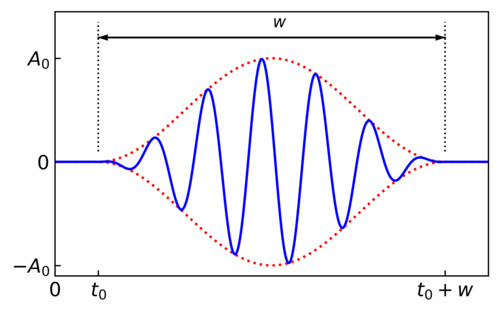" width="450" align="left"/>
</figure>

After some time $t$ when the pump is not acting any longer, we can consider a delta-kick as the probe

\begin{equation}
\tag{3}
\mathbf{A}_\textrm{probe}(t) = -c\,\mathbf{E}'_0\, u( t-t_\textrm{probe} ),
\end{equation}

where $u( t-t_\textrm{probe} )$ is a step-function applied at time $t=t_\textrm{probe}$. The electric field of the probe is

\begin{equation}
\tag{4}
\mathbf{E}_\textrm{probe}(t)=-\frac{1}{c}\frac{d}{dt}\mathbf{A}_\textrm{probe}(t) = \mathbf{E}'_0\, \delta( t-t_\textrm{probe} )\:.
\end{equation}

In this tutorial, we will analyze how the imaginary part of the dielectric function (related to the absorption spectrum) of the sample excited by the pump differs from its ordinary counterpart (evaluated starting with the sample on the ground state). With this purpose, we consider the general relationship between the Fourier-transforms of the current density $J$ and the electric field $E$:

\begin{equation}
\tag{5}
\sigma_{\alpha\beta}(\omega) = \frac{J_\alpha(\omega)}{E_\beta(\omega)}, \quad \quad\varepsilon_{\alpha\beta}(\omega) = \delta_ {\alpha\beta}+ \frac{4\pi \mathrm{i}\,\sigma_{\alpha\beta}(\omega)}{\omega},
\end{equation}

in which $\sigma$ and $\varepsilon$ are the optical conductivity and the dielectric tensors, respectively; the indexes $\alpha$, $\beta$ denote the cartesian directions x, y, or z **[<span style="color:firebrick">[1]</span>](#4)**.

To simulate the pump-probe experiment, we can evaluate the dielectric function as indicated in Eq. (5), but taking the current density as the difference between the values after the pump and the probe ($J_\textrm{pump-probe}$) and the pump pulse $J_\textrm{pump}$, as obtained from two separate calculations. And as comparison, we consider a third calculation just with the probe pulse, from which we can extract the dielectric function from the system starting on the groundstate.

Please refer to **[<span style="color:firebrick">Ref [2]</span>](#4)** for one different example of simulation of pump-probe spectroscopy with **`exciting`**.

<a id='2'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">2. Ground-State Calculation</span>

**<span style="color:#15317E">i) Preparation of the Input File</span>**

The first step is to create a directory for the system that we want to investigate, **run_MoS2_pump_probe** and a subdirectory for the ground-state calculation, **GS**.

In [1]:
%%bash
mkdir -p run_MoS2_pump_probe && cd run_MoS2_pump_probe
mkdir -p  GS
cd ..

As initial condition for the time evolution done in **RT-TDDFT**, we need the electron density and potential from a ground-state calculation. Therefore, we create the file **input.xml** that could look like the following:

<span class="MoS2_RT_TDDFT"></span>
```xml
<input>
 
   <title>MoS2</title>
 
   <structure speciespath="$EXCITINGROOT/species/">
      <crystal scale="6.0274">
         <basevect>  0.5  0.86602540378   0.0 </basevect>
         <basevect> -0.5  0.86602540378   0.0 </basevect>
         <basevect>  0.0  0.00000000000  10.0 </basevect>
      </crystal>
      <species speciesfile="Mo.xml" rmt="2.3">
         <atom coord="0.666667  0.666667  0.0"/>
      </species>
      <species speciesfile="S.xml"  rmt="2.05">
         <atom coord="0.333333  0.333333 -0.04938"/>
         <atom coord="0.333333  0.333333  0.04938"/>
      </species>
   </structure>
 
   <groundstate
      do="fromscratch"
      xctype="LDA_PW"
      ngridk="12 12 1"
      rgkmax="5.0d0"
      nempty="5"
      epsengy="1.d-8">
   </groundstate>
 
</input>
```

In [2]:
import os
from excitingjupyter.utilities import get_input_xml_from_notebook   

# Extract input file content from this notebook:
input_str = get_input_xml_from_notebook("05_tutorial_simulating_pump_probe_spectroscopy_with_rt_tddft", "MoS2_RT_TDDFT")

# Write out the input as an XML file:
with open('./run_MoS2_pump_probe/GS/input.xml', "w") as fid:
    fid.write(input_str)

Do not forget to replace in the **input.xml** the actual value of the environment variable **$EXCITINGROOT**. You can do this by directly editing the **input.xml** file or by using the following command:

In [3]:
%%bash
cd run_MoS2_pump_probe/GS
python3 -m excitingscripts.setup.excitingroot
cd ../..

<a id='2.1'></a>
**<span style="color:#15317E">ii) Running the Ground-State Calculation</span>**

You can start the calculation by invoking the script **`excitingscripts.execute.single`**.

In [4]:
%%bash
cd run_MoS2_pump_probe
python3 -m excitingscripts.execute.single -r GS
cd ..

You can check the output files, especially the main output file **INFO.OUT**, for general information. In the case of a successfully finished calculation, the last lines of the **INFO.OUT** will contain the message

```
...
================================================================================
| EXCITING NEON stopped                                                        =
================================================================================
```

Check if this is indeed the case and if the **EFERMI.OUT** and **STATE.OUT** files are present. They contain the **<span style="color:green">Fermi level</span>** and the converged **<span style="color:green">electron density and potential</span>**, respectively, and are the starting point of the **RT-TDDFT** calculation.

**<span style="color:firebrick">Please note</span>**: To obtain reliable results it is necessary to perform careful convergence tests with respect to the **k**-point mesh (parameter <code><span style="color:mediumblue">ngridk</span></code>) and the size of the basis set (parameter <code><span style="color:mediumblue">rgkmax</span></code>). For details see the tutorial **Simple convergence tests**.

<a id='3'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">3. Performing the Pump-Probe Calculations</span>

**<span style="color:#15317E">i) First Case: Pump-Probe</span>**

Create a new subdirectory **pump_probe**. You can prepare the input file (**input.xml**) of a **RT-TDDFT** calculation starting from the existing groundstate input file. Copy the following files to the current directory. You can perform all of this with the following commands:

In [9]:
%%bash
cd run_MoS2_pump_probe
mkdir -p pump_probe && cd pump_probe
cp ../GS/{input.xml,EFERMI.OUT,STATE.OUT} .
cd ../..

The explicit ground-state calculation can be avoided with the attribute <code><span style="color:mediumblue">do</span>=<span style="color:firebrick">"skip"</span></code> inside the element <code><span style="color:green">groundstate</span></code>.

```xml
...
   <groundstate 
      do="skip"
      ... >
      ...
   </groundstate>
...

```
In order to perform a **"RT-TDDFT"** calculation, the element <code><span style="color:green">xs</span></code>, must be added to the input file inside the <code><span style="color:green">input</span></code> element, as shown below.

```xml
...
   <xs
      xstype="RT-TDDFT"
      ngridk="6 6 1"
      vkloff="0.01 0.02 0.004"
      nempty="5"
      nosym="true"
      reducek="false">
 
      <realTimeTDDFT
         propagator="AETRS"
         timeStep="0.5d0"
         endTime="500.d0"
         vectorPotentialSolver="improvedeuler">
         <laser fieldType="total">
            <sinSq amplitude="20.d0" omega="0.5d0" phase="0.d0"
               t0="0.1d0" pulseLength="80.d0" direction="x" />
            <kick amplitude="0.1d0" t0="100.d0" width="0.d0" direction="x" />
         </laser>
         <pmat readFromFile="false" writeToFile="false" forceHermitian="false" />
      </realTimeTDDFT>
   </xs>
...

```

In [5]:
# The following lines modify the input.xml using Python
from excitingtools import ExcitingInputXML, ExcitingXSInput

parsed_input = ExcitingInputXML.from_xml('./run_MoS2_pump_probe/pump_probe/input.xml')

xs = {'xstype': 'RT-TDDFT',
      'ngridk': [6, 6, 1],
      'vkloff': [0.01, 0.02, 0.004],
      'nempty': 5,
      'nosym': True,
      'reducek': False,
      'realTimeTDDFT': {'propagator': 'AETRS', 'timeStep': 0.5, 'endTime': 500.0,
                        'vectorPotentialSolver': 'improvedeuler',
                        'laser': {'fieldType': 'total', 'sinSq': [{'amplitude': 20.0, 'omega': 0.5, 'phase': 0.0,
                                                                   't0': 0.1, 'pulseLength': 80.0, 
                                                                   'direction': 'x'}],
                                  'kick': [{'amplitude': 0.1, 't0': 100.0, 'width': 0.0, 'direction': 'x'}]},
                        'pmat': {'readFromFile': False, 'writeToFile': False, 'forceHermitian': False}}}

parsed_input.xs = ExcitingXSInput(**xs)
parsed_input.groundstate.do = "skip"

parsed_input.write('./run_MoS2_pump_probe/pump_probe/input.xml')

Please check all relevant parameters for a **"RT-TDDFT"** calculation in **[Input Reference](https://www.exciting-code.org/home/about/input-reference)**.

Having modified the input file as described above, you can launch the **RT-TDDFT** calculation inside the subdirectory **pump_probe** using

In [ ]:
%%bash
cd run_MoS2_pump_probe
python3 -m excitingscripts.execute.single -r pump_probe
cd ..

<a id='3.1'></a>
Be aware that, depending on the computer you are using, this calculation may take several minutes up to some hours.

**<span style="color:#15317E">ii) Second Case: Pump</span>**

Now, we can study the effect of the pump alone on MoS<sub>2</sub>. Create a new subdirectory named **pump**, and enter it. Copy the files **input.xml**, **EFERMI.OUT** and **STATE.OUT** from the ground-state calculation to the current directory:

In [15]:
%%bash
cd run_MoS2_pump_probe
mkdir -p pump && cd pump
cp ../GS/{input.xml,EFERMI.OUT,STATE.OUT} .
cd ../..

As done before, edit the file **input.xml** to avoid the explicit ground-state calculation by setting <code><span style="color:mediumblue">do</span>=<span style="color:firebrick">"skip"</span></code> inside the element <code><span style="color:green">groundstate</span></code>.

Now you need to add the element <code><span style="color:green">xs</span></code> as shown below.

```xml
...
   <xs
      xstype="RT-TDDFT"
      ngridk="6 6 1"
      vkloff="0.01 0.02 0.004"
      nempty="5"
      nosym="true"
      reducek="false">
 
      <realTimeTDDFT
         propagator="AETRS"
         timeStep="0.5d0"
         endTime="500.d0"
         vectorPotentialSolver="improvedeuler">
         <laser fieldType="total">
            <sinSq amplitude="20.d0" omega="0.5d0" phase="0.d0"
               t0="0.1d0" pulseLength="80.d0" direction="x" />
         </laser>
         <pmat readFromFile="false" writeToFile="false" forceHermitian="false" />
      </realTimeTDDFT>
   </xs>
...
```

In [19]:
# The following lines modify the input.xml using Python
parsed_input = ExcitingInputXML.from_xml('./run_MoS2_pump_probe/pump/input.xml')

xs = {'xstype': 'RT-TDDFT',
      'ngridk': [6, 6, 1],
      'vkloff': [0.01, 0.02, 0.004],
      'nempty': 5,
      'nosym': True,
      'reducek': False,
      'realTimeTDDFT': {'propagator': 'AETRS', 'timeStep': 0.5, 'endTime': 500.0, 
                        'vectorPotentialSolver': 'improvedeuler',
                        'laser': {'fieldType': 'total', 'sinSq': [{'amplitude': 20.0, 'omega': 0.5, 'phase': 0.0,
                                                                   't0': 0.1, 'pulseLength': 80.0, 
                                                                   'direction': 'x'}]},
                        'pmat': {'readFromFile': False, 'writeToFile': False, 'forceHermitian': False}}}
          

parsed_input.xs = ExcitingXSInput(**xs)
parsed_input.groundstate.do = "skip"

parsed_input.write('./run_MoS2_pump_probe/pump/input.xml')

Now you are ready to execute the **RT-TDDFT** calculation inside the subdirectory **pump** using

In [ ]:
%%bash
cd run_MoS2_pump_probe
python3 -m excitingscripts.execute.single -r pump
cd ..

<a id='3.2'></a>
Have in mind that depending on your computational resources, this calculation may take some minutes or even hours.

**<span style="color:#15317E">iii) Third Case: Probe</span>**

Finally, we can carry out a calculation to obtain the dielectric function of  MoS<sub>2</sub> starting from the groundstate. Similar as you did before, you need to go to the previous directory, create a new one named **probe**, and enter it. You can again copy the files **input.xml**, **EFERMI.OUT** and **STATE.OUT** from the ground-state calculation to the current directory:

In [21]:
%%bash
cd run_MoS2_pump_probe
mkdir -p probe && cd probe
cp ../GS/{input.xml,EFERMI.OUT,STATE.OUT} .
cd ../..

As done before, edit the file **input.xml** to skip the ground-state calculation and add the element <code><span style="color:green">xs</span></code> as shown below.

```xml
...
  <xs
      xstype="RT-TDDFT"
      ngridk="6 6 1"
      vkloff="0.01 0.02 0.004"
      nempty="5"
      nosym="true"
      reducek="false">
 
      <realTimeTDDFT
         propagator="AETRS"
         timeStep="0.5d0"
         endTime="500.d0"
         vectorPotentialSolver="improvedeuler">
         <laser fieldType="total">
            <kick amplitude="0.1d0" t0="100.d0" width="0.d0" direction="x" />
         </laser>
         <pmat readFromFile="false" writeToFile="false" forceHermitian="false" />
      </realTimeTDDFT>
   </xs>
...
```

In [22]:
# The following lines modify the input.xml using Python
parsed_input = ExcitingInputXML.from_xml('./run_MoS2_pump_probe/probe/input.xml')

xs = {'xstype': 'RT-TDDFT',
      'ngridk': [6, 6, 1],
      'vkloff': [0.01, 0.02, 0.004],
      'nempty': 5,
      'nosym': True,
      'reducek': False,
      'realTimeTDDFT': {'propagator': 'AETRS', 'timeStep': 0.5, 'endTime': 500.0, 
                        'vectorPotentialSolver': 'improvedeuler',
                        'laser': {'fieldType': 'total',
                                  'kick': [{'amplitude': 0.1, 't0': 100.0, 'width': 0.0, 'direction': 'x'}]},
                        'pmat': {'readFromFile': False, 'writeToFile': False, 'forceHermitian': False}}}
          

parsed_input.xs = ExcitingXSInput(**xs)
parsed_input.groundstate.do = "skip"

parsed_input.write('./run_MoS2_pump_probe/probe/input.xml')

Then, perform the **RT-TDDFT** calculation (inside the subdirectory **probe**) using

In [ ]:
%%bash
cd run_MoS2_pump_probe
python3 -m excitingscripts.execute.single -r probe
cd ..

<a id='3.3'></a>
As warned before, this calculation may take more some minutes or hours, depending on the computational power that you have.

**<span style="color:#15317E">iv) Analyzing the Dielectric Function</span>**

First, it is convenient to obtain the difference $J_\textrm{pump-probe}-J_\textrm{pump}$. We first move to the parent directory and then preprocess the files **JIND.OUT** in the folders **pump_probe** and **pump** with the command:

In [3]:
%%bash
cd run_MoS2_pump_probe
python3 -m excitingscripts.plot.multitask --preprocess --sub -f pump_probe/JIND.OUT pump/JIND.OUT -o DIFF.OUT
cd ..

With the previous command, the difference $J_\textrm{pump-probe}-J_\textrm{pump}$ is stored in the file **DIFF.OUT**. It assumes that we take the **x** components, otherwise, we would need to add **--y** or **--z**.

Now, you can plot the current densities $J_\textrm{pump}$, $J_\textrm{probe}$, $J_\textrm{pump-probe}$ and the difference $J_\textrm{pump-probe}-J_\textrm{pump}$ with **[<span style="color:firebrick">[3]</span>](#4)**:

In [6]:
%%bash
cd run_MoS2_pump_probe
python3 -m excitingscripts.plot.multitask --jind -f pump/JIND.OUT probe/JIND.OUT pump_probe/JIND.OUT DIFF.OUT --legend 'lower right' --plot_name 'JIND'
cd ..

Your figure should be similar to the one given bellow:

<figure>
<img src=" 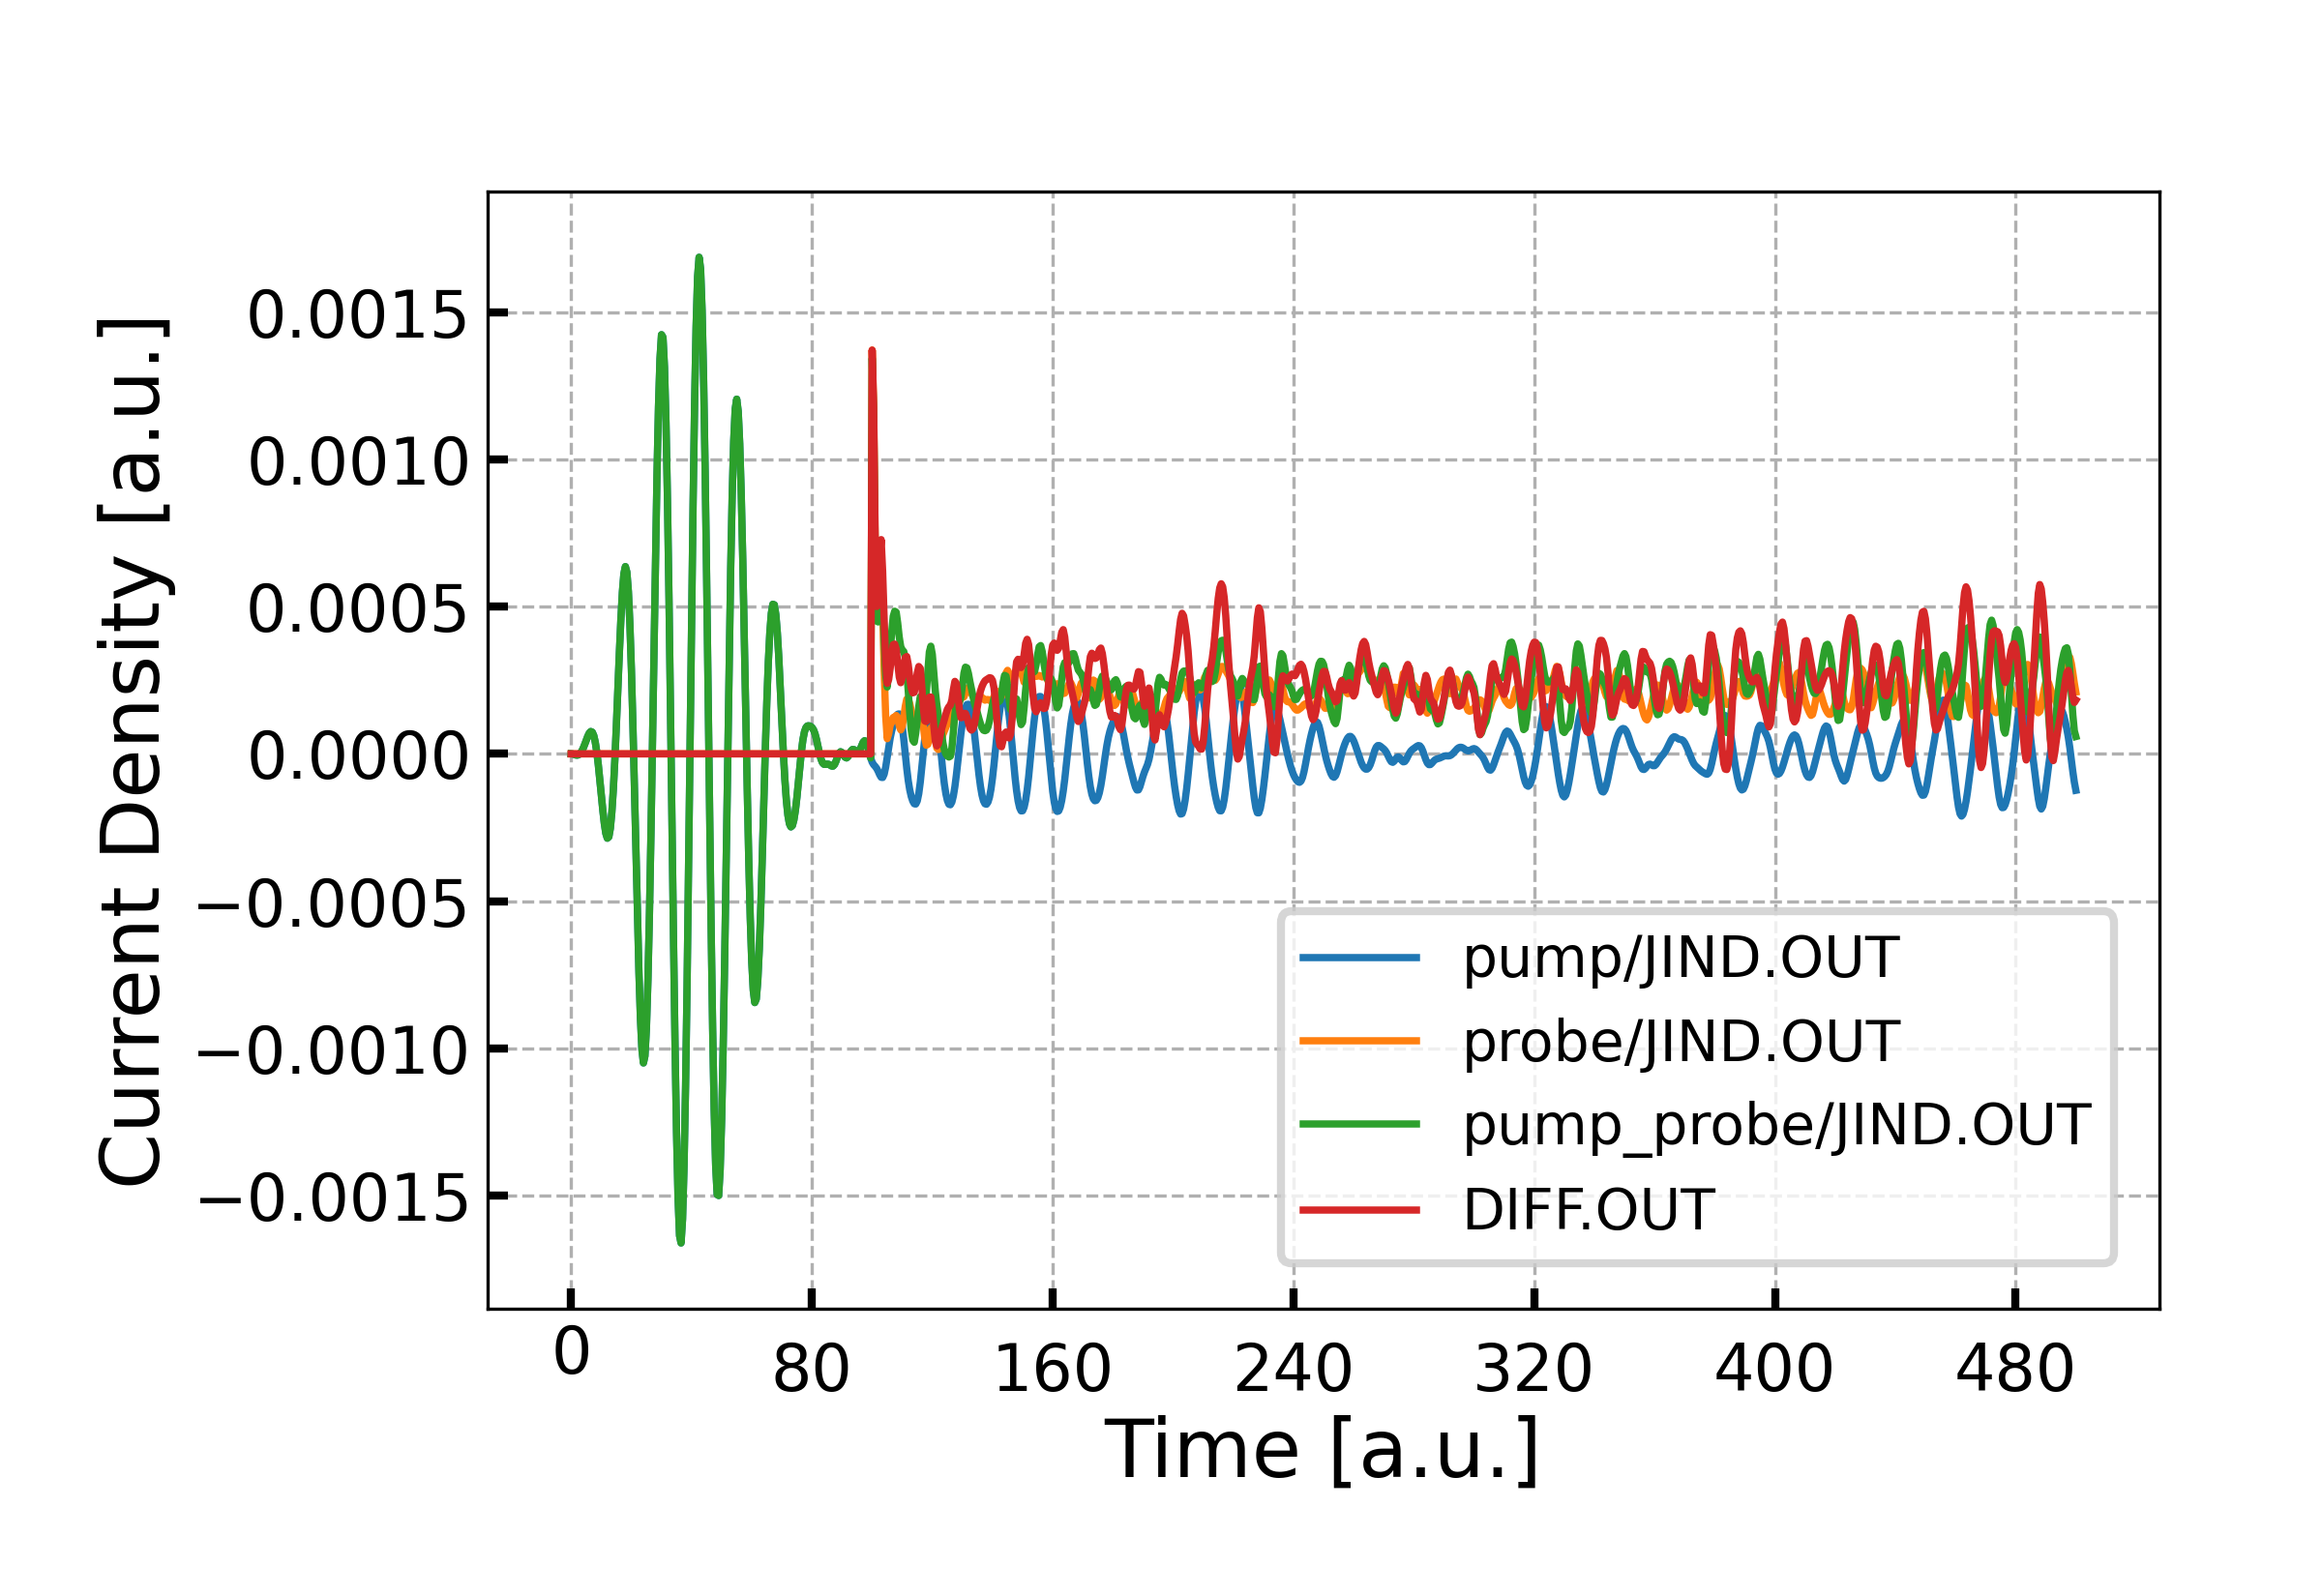" width="600" align="left"/>
</figure>


Now, we can compare the imaginary part dielectric function in the **pump-probe** case, and compare it with the **probe** case. First, we determine the dielectric function for the **probe** case:

In [12]:
%%bash
cd run_MoS2_pump_probe/probe
python3 -m excitingscripts.plot.multitask --preprocess --get_eps --xx -f AVEC.OUT -f JIND.OUT --wcut 0.05 -o EPSILON.OUT
cd ../..

Now, we move back to parent directory, and obtain the dielectric function for the **pump-probe**:

In [13]:
%%bash
cd run_MoS2_pump_probe
python3 -m excitingscripts.plot.multitask --preprocess --get_eps --xx -f probe/AVEC.OUT -f DIFF.OUT --wcut 0.05 -o EPSILON-DIFF.OUT
cd ..

And, finally, we can plot the imaginary part of both dielectric functions in the same figure using:

In [7]:
%%bash
cd run_MoS2_pump_probe
python3 -m excitingscripts.plot.multitask --imag_eps -f probe/EPSILON.OUT EPSILON-DIFF.OUT --xlim 5 30 --ylim 0 1 --plot_name 'EPSILON'
cd ..

Your figure should be similar to the one bellow:
    
<figure>
<img src=" 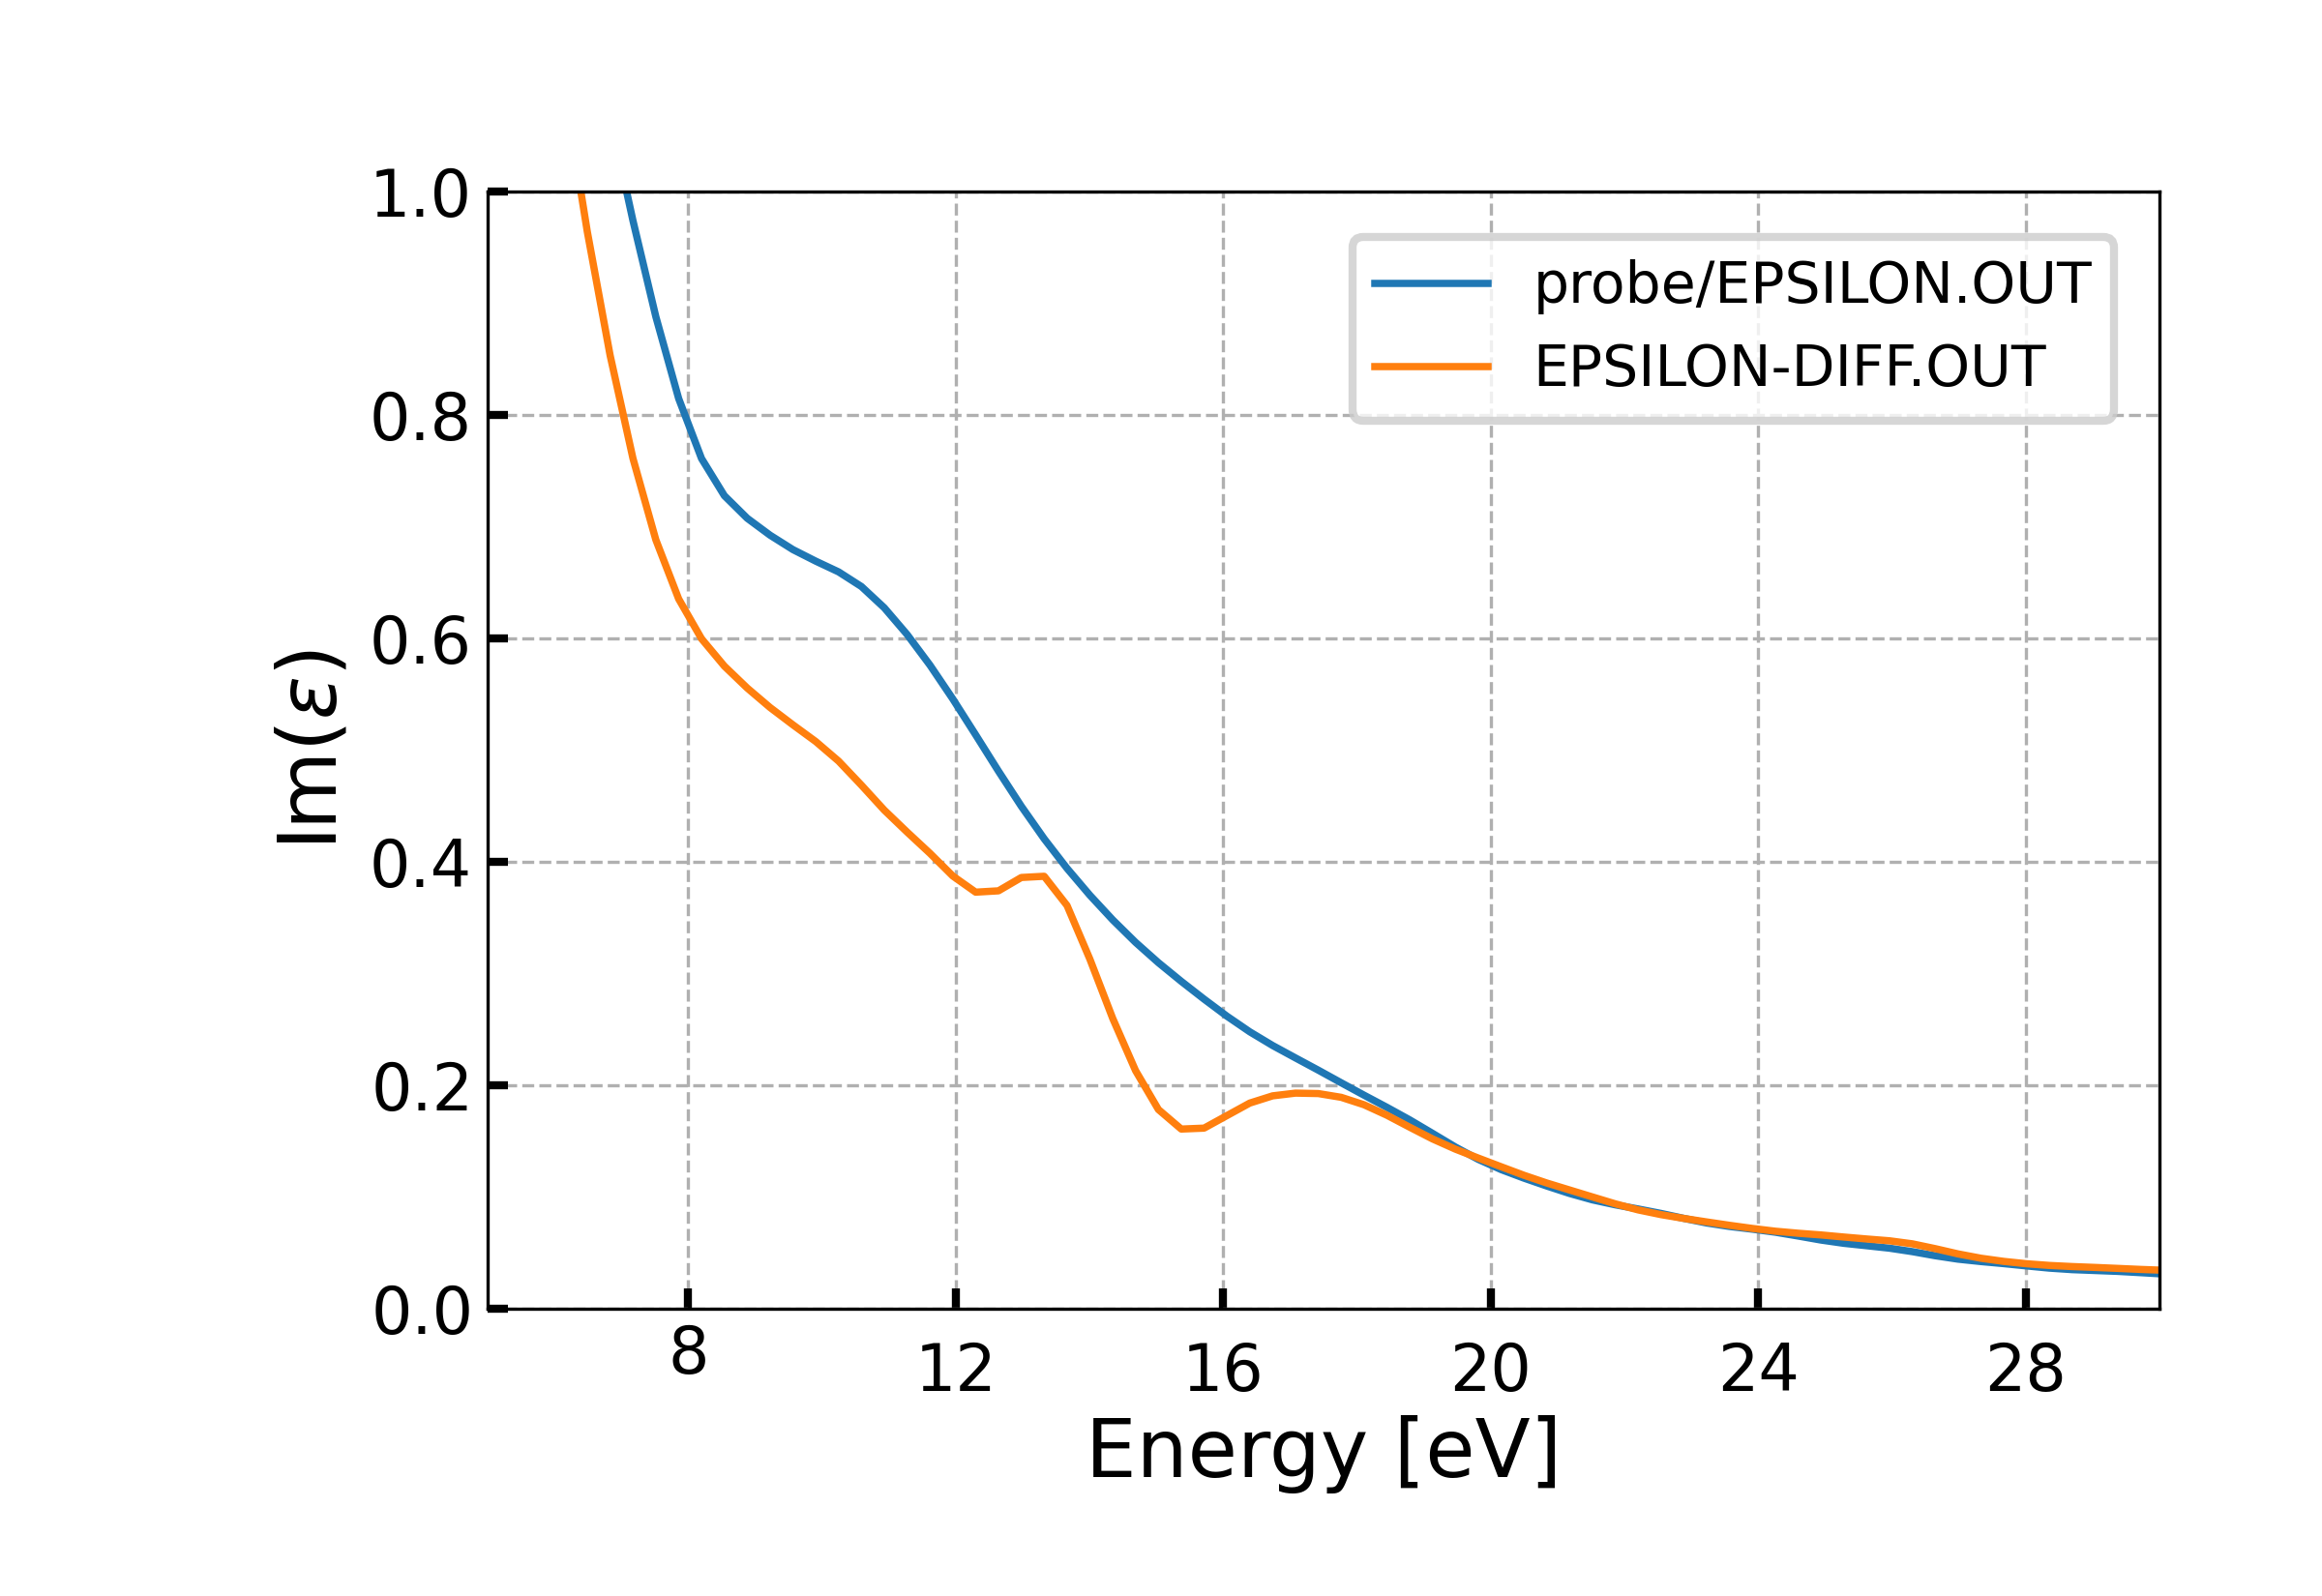" width="600" align="left"/>
</figure>

Be aware that the calculations shown here employ parameters which are not converged, and should be considered only for introductory purposes. To improve the quality of the calculation, special attention needs to be paid to the following parameters:

- <code><span style="color:mediumblue">ngridk</span></code>
- <code><span style="color:mediumblue">rgkmax</span></code>
- <code><span style="color:mediumblue">timeStep</span></code> and <code><span style="color:mediumblue">endTime</span></code>

<a id='4'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">Bibliography</span>

1. Note that to obtain $\sigma_{\beta\alpha}$ it is convenient to take electric field as a delta-kick $E_0\,\delta(t)$ in a specific direction $\alpha$ such that $E_\alpha(\omega) = E_0$.
2. Ronaldo Rodrigues Pela, Claudia Draxl. "All-electron full-potential implementation of real-time **TDDFT** in exciting" (**[link](https://iopscience.iop.org/article/10.1088/2516-1075/ac0c26)**).
3. More information about the script **`excitingscripts.plot.multitask`** can be found **[here](https://www.exciting-code.org/home/the-python-script-plot.multitask)**

<hr style="border:2px solid #DDD"> </hr>